### Ship Sighting Extraction

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import seaborn as sns

In [2]:
df = pd.read_csv('Tier5_logentries-export-2024-08-20.csv',low_memory = False) 
df.head()

,DateTime,ID,LogBook ID,Page,Latitude,Longitude,Infilled,Depth,Depth Unit,Bottom,...,Tier4_new,Six Day Dist,Tier 5 Infilled,Six Day Lat,Six Day Lon,Seven Day Dist,Seven Day Lat,Seven Day Lon,Tier5_usable,Tier5_new
0,1853-07-06 12:00:00,2442.0,A. Houghton (bark) 1853-1857,NaN,37.850000,-58.466667,False,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
1,1853-07-07 12:00:00,2443.0,A. Houghton (bark) 1853-1857,NaN,37.250000,-55.066667,False,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
2,1853-07-08 12:00:00,2445.0,A. Houghton (bark) 1853-1857,NaN,35.000000,-53.400000,False,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,1853-07-09 12:00:00,2446.0,A. Houghton (bark) 1853-1857,NaN,33.750000,-52.466667,False,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
4,1853-07-10 12:00:00,2447.0,A. Houghton (bark) 1853-1857,NaN,33.333333,-53.716667,False,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False


In [3]:
# Columns to keep
columns_to_keep = ['DateTime', 'ID', 'LogBook ID', 'Latitude', 'Longitude',
                   'Wind Speed/Force', 'Wind Force', 'Ship Sightings']

# Drop columns except for the ones to keep
df = df[columns_to_keep]

In [4]:
# converting 'DateTime' column to actual DateTime and calling it "Entry Date Time"
df['Entry Date Time'] = pd.to_datetime(df.DateTime, format = '%Y-%m-%d %H:%M:%S')

In [5]:
#Creating a dataframe of usable data
#df['usable'] = (df["Latitude"].notna() & df["Longitude"].notna() & df["Ship Sightings"].notna())
df['usable'] = (df["Latitude"].notna() & df["Longitude"].notna() & df["Ship Sightings"].notna() & df["Wind Force"].notna())
df_u = df[df['usable']==True].copy()
df_u

,DateTime,ID,LogBook ID,Latitude,Longitude,Wind Speed/Force,Wind Force,Ship Sightings,Entry Date Time,usable
1036,1847-12-02 12:00:00,19631.0,Abigail (ship) 1847-1850,17.050000,-25.466667,light winds,2.0,"""the Bark (Hope) in company""",1847-12-02 12:00:00,True
1037,1847-12-03 12:00:00,19632.0,Abigail (ship) 1847-1850,16.633333,-26.066667,light winds,2.0,"""the Bark (Hope) in company""",1847-12-03 12:00:00,True
1040,1847-12-06 12:00:00,19646.0,Abigail (ship) 1847-1850,14.866667,-24.733333,strong winds,6.0,"""in company with the Bark (Hope)""",1847-12-06 12:00:00,True
1092,1848-01-27 12:00:00,19832.0,Abigail (ship) 1847-1850,-55.933333,-65.666667,light winds,2.0,"""exchanged signals with...the Staphania (Steph...",1848-01-27 12:00:00,True
1121,1848-02-25 12:00:00,19878.0,Abigail (ship) 1847-1850,-33.750000,-80.750000,strong winds,6.0,"""the Emerald came down""",1848-02-25 12:00:00,True
...,...,...,...,...,...,...,...,...,...,...
103752,1839-09-08 12:00:00,107559.0,Young Phenix (ship) 1836-1840,-10.083333,123.633333,fresh breezes,5.0,"""spoke the Barclay of New Bedford""",1839-09-08 12:00:00,True
103753,1839-09-09 12:00:00,107560.0,Young Phenix (ship) 1836-1840,-9.400000,123.783333,light breezes,2.0,"""in company with the ship Barclay""",1839-09-09 12:00:00,True
103789,1839-10-15 12:00:00,107907.0,Young Phenix (ship) 1836-1840,-13.400000,112.433333,light breezes,2.0,"""spoke teh Clifford Wayne of Fair Haven 23 mon...",1839-10-15 12:00:00,True
103822,1839-11-17 12:00:00,108075.0,Young Phenix (ship) 1836-1840,-13.200000,113.783333,strong breezes,6.0,saw the Samuel Enderby of London,1839-11-17 12:00:00,True


In [6]:
# convert values in 'LogBook ID' to strings
ship_id = df_u['LogBook ID'].map(str)
# extract ship names (Capitalized words)
ship_names = ship_id.apply(lambda x : re.findall(r'\b[A-Z][a-z]+\b',x))

In [8]:
# flatten the list of ship names in to a single list
ship_names_flat = [item for sublist in ship_names for item in sublist]
# get unique sdhip names
unique_ships = list(pd.Series(ship_names_flat).unique()) 
# identify common capitalized words in data set that are unlikely to be ship names
stopwords = ['Bark', 'Ship',"St"]
# remove words in 'stopwords'
for word in list(unique_ships):
    if word in stopwords:
        unique_ships.remove(word)

In [11]:
# identify rows where the 'Ship Sightings' column contains one of the unique ship names identified
df_u.loc[:, 'matches'] = np.where(
    df_u['Ship Sightings'].str.contains('|'.join(unique_ships)), 'match', 'not match')


In [17]:
# markj rows where a match was found from 'LogBook ID' column
df_u.loc[:, 'logbook_match'] = np.where(df_u['LogBook ID'].fillna('').str.contains('|'.join(unique_ships), case=False), 'match', 'not match')

# mark rows where a match was found from 'Ship Sightings' column
df_u.loc[:, 'sightings_match'] = np.where(df_u['Ship Sightings'].fillna('').str.contains('|'.join(unique_ships), case=False), 'match', 'not match')


In [20]:
# seperate data frames of 'logbook id' matches and 'ship sightings' matches
df_logbook_matches = df_u[df_u['logbook_match'] == 'match'].copy()
df_sightings_matches = df_u[df_u['sightings_match'] == 'match'].copy()

In [21]:
# extract the matching ship names from 'logbook i'd and 'ship sightings' columns
df_logbook_matches.loc[:, 'Matched_Ship'] = df_logbook_matches['LogBook ID'].str.extract('(' + '|'.join(unique_ships) + ')', expand=False)
df_sightings_matches.loc[:, 'Matched_Ship'] = df_sightings_matches['Ship Sightings'].str.extract('(' + '|'.join(unique_ships) + ')', expand=False)

# merge the dataframes on that matched ship name and add suffixes _1 and _2
df_final = df_logbook_matches.merge(df_sightings_matches, on='Matched_Ship', suffixes=('_1', '_2'))

# reset the index 
df_final.reset_index(drop=True, inplace=True)

# remove instances where the two ships are the same
df_final = df_final[df_final['LogBook ID_1'] != df_final['LogBook ID_2']]

In [16]:
df_final

,DateTime_1,ID_1,LogBook ID_1,Latitude_1,Longitude_1,Wind Speed/Force_1,Wind Force_1,Ship Sightings_1,Entry Date Time_1,usable_1,...,Latitude_2,Longitude_2,Wind Speed/Force_2,Wind Force_2,Ship Sightings_2,Entry Date Time_2,usable_2,matches_2,logbook_match_2,sightings_match_2
0,1848-01-27 12:00:00,19832.0,Abigail (ship) 1847-1850,-55.933333,-65.666667,light winds,2.0,"""exchanged signals with...the Staphania (Steph...",1848-01-27 12:00:00,True,...,64.145238,-173.450000,strong breezes,6.0,Saratoga Abigail,1851-07-10 12:00:00,True,match,match,match
1,1848-01-27 12:00:00,19832.0,Abigail (ship) 1847-1850,-55.933333,-65.666667,light winds,2.0,"""exchanged signals with...the Staphania (Steph...",1848-01-27 12:00:00,True,...,55.816667,142.000000,fresh breezes,5.0,The Abigail of New Bedford,1853-07-01 12:00:00,True,match,match,match
2,1848-01-27 12:00:00,19832.0,Abigail (ship) 1847-1850,-55.933333,-65.666667,light winds,2.0,"""exchanged signals with...the Staphania (Steph...",1848-01-27 12:00:00,True,...,54.533333,145.133333,fresh breezes,5.0,Spoke with Bark Abigail of New Bedford,1865-05-20 12:00:00,True,match,match,match
3,1848-01-27 12:00:00,19832.0,Abigail (ship) 1847-1850,-55.933333,-65.666667,light winds,2.0,"""exchanged signals with...the Staphania (Steph...",1848-01-27 12:00:00,True,...,-5.500000,-103.000000,strong trades,6.0,Abigail of New Bedford,1845-12-18 12:00:00,True,match,match,match
4,1848-01-27 12:00:00,19832.0,Abigail (ship) 1847-1850,-55.933333,-65.666667,light winds,2.0,"""exchanged signals with...the Staphania (Steph...",1848-01-27 12:00:00,True,...,-7.666667,-87.000000,fresh breezes,5.0,"""spoke the ship Abigail (of Nantucket) Capt Cl...",1832-09-03 12:00:00,True,match,match,match
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56167,1839-10-15 12:00:00,107907.0,Young Phenix (ship) 1836-1840,-13.400000,112.433333,light breezes,2.0,"""spoke teh Clifford Wayne of Fair Haven 23 mon...",1839-10-15 12:00:00,True,...,-5.416667,-82.333333,brisk trades,5.0,"""saw the Young Phenix""",1827-05-16 12:00:00,True,match,match,match
56168,1839-10-15 12:00:00,107907.0,Young Phenix (ship) 1836-1840,-13.400000,112.433333,light breezes,2.0,"""spoke teh Clifford Wayne of Fair Haven 23 mon...",1839-10-15 12:00:00,True,...,-5.416667,-82.500000,strong winds,6.0,"""saw the Young Phenix""",1827-05-17 12:00:00,True,match,match,match
56169,1839-10-15 12:00:00,107907.0,Young Phenix (ship) 1836-1840,-13.400000,112.433333,light breezes,2.0,"""spoke teh Clifford Wayne of Fair Haven 23 mon...",1839-10-15 12:00:00,True,...,-5.966667,-82.666667,light winds,2.0,"""the Young Phenix in sight""",1827-05-18 12:00:00,True,match,match,match
56170,1839-10-15 12:00:00,107907.0,Young Phenix (ship) 1836-1840,-13.400000,112.433333,light breezes,2.0,"""spoke teh Clifford Wayne of Fair Haven 23 mon...",1839-10-15 12:00:00,True,...,-5.333333,-82.559524,light winds,2.0,"""the Young Phenix in company""",1827-05-24 12:00:00,True,match,match,match


In [22]:
#columns to keep
columns_to_keep = ['ID_1','LogBook ID_1','Latitude_1','Longitude_1','Wind Speed/Force_1',
                   'Wind Force_1','Ship Sightings_1','Entry Date Time_1','Matched_Ship',
                   'ID_2','LogBook ID_2','Latitude_2','Longitude_2','Wind Speed/Force_2','Wind Force_2',
                   'Ship Sightings_2','Entry Date Time_2']
#drop columns except ones to keep
df_final = df_final[columns_to_keep]

In [23]:
# calculate distance between the two ships
from geopy.distance import geodesic

def calculate_distances(df):
    distances = []
    for i in range(len(df)):
        point1 = (df.iloc[i]['Latitude_1'], df.iloc[i]['Longitude_1'])
        point2 = (df.iloc[i]['Latitude_2'], df.iloc[i]['Longitude_2'])
        distance = geodesic(point1, point2).kilometers  # Calculate distance in km
        distances.append(distance)
    return distances



# Apply the function and create a new column for distance
df_final = df_final.assign(Distance_km=calculate_distances(df_final))

In [25]:
# Calculate difference in dates between ships
df_final['Date Difference'] = (df_final['Entry Date Time_1'] - df_final['Entry Date Time_2']).abs()
# Calculate differene in wind force
df_final['Wind Force Difference'] = (df_final['Wind Force_1'] - df_final['Wind Force_2']).abs()
#view Final dataframe
df_final

,ID_1,LogBook ID_1,Latitude_1,Longitude_1,Wind Speed/Force_1,Wind Force_1,Ship Sightings_1,Entry Date Time_1,Matched_Ship,ID_2,LogBook ID_2,Latitude_2,Longitude_2,Wind Speed/Force_2,Wind Force_2,Ship Sightings_2,Entry Date Time_2,Distance_km,Date Difference,Wind Force Difference
0,19631.0,Abigail (ship) 1847-1850,17.050000,-25.466667,light winds,2.0,"""the Bark (Hope) in company""",1847-12-02 12:00:00,Abigail,68845.0,Charles Phelps (Ship) 1850-1853,64.145238,-173.450000,strong breezes,6.0,Saratoga Abigail,1851-07-10 12:00:00,10594.040197,1316 days,4.0
1,19631.0,Abigail (ship) 1847-1850,17.050000,-25.466667,light winds,2.0,"""the Bark (Hope) in company""",1847-12-02 12:00:00,Abigail,80900.0,Harrison (Ship) 1850-1854,55.816667,142.000000,fresh breezes,5.0,The Abigail of New Bedford,1853-07-01 12:00:00,11844.690144,2038 days,3.0
2,19631.0,Abigail (ship) 1847-1850,17.050000,-25.466667,light winds,2.0,"""the Bark (Hope) in company""",1847-12-02 12:00:00,Abigail,66825.0,Java (Bark) 1864-1867,54.533333,145.133333,fresh breezes,5.0,Spoke with Bark Abigail of New Bedford,1865-05-20 12:00:00,12022.816528,6379 days,3.0
3,19631.0,Abigail (ship) 1847-1850,17.050000,-25.466667,light winds,2.0,"""the Bark (Hope) in company""",1847-12-02 12:00:00,Abigail,26046.0,Lafayette (Ship) 1844-1847,-5.500000,-103.000000,strong trades,6.0,Abigail of New Bedford,1845-12-18 12:00:00,8877.720237,714 days,4.0
4,19631.0,Abigail (ship) 1847-1850,17.050000,-25.466667,light winds,2.0,"""the Bark (Hope) in company""",1847-12-02 12:00:00,Abigail,37537.0,Leonidas (ship) 1830-1833,-7.666667,-87.000000,fresh breezes,5.0,"""spoke the ship Abigail (of Nantucket) Capt Cl...",1832-09-03 12:00:00,7300.490741,5568 days,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152003,108495.0,Young Phenix (ship) 1836-1840,-33.883333,18.433333,light winds,2.0,"""ship Pocahontas came into the harbor""",1840-01-26 12:00:00,Young,24193.0,Phoebe Ann (Ship) 1826-1829,-5.416667,-82.333333,brisk trades,5.0,"""saw the Young Phenix""",1827-05-16 12:00:00,10667.434535,4638 days,3.0
152004,108495.0,Young Phenix (ship) 1836-1840,-33.883333,18.433333,light winds,2.0,"""ship Pocahontas came into the harbor""",1840-01-26 12:00:00,Young,24194.0,Phoebe Ann (Ship) 1826-1829,-5.416667,-82.500000,strong winds,6.0,"""saw the Young Phenix""",1827-05-17 12:00:00,10682.583984,4637 days,4.0
152005,108495.0,Young Phenix (ship) 1836-1840,-33.883333,18.433333,light winds,2.0,"""ship Pocahontas came into the harbor""",1840-01-26 12:00:00,Young,24195.0,Phoebe Ann (Ship) 1826-1829,-5.966667,-82.666667,light winds,2.0,"""the Young Phenix in sight""",1827-05-18 12:00:00,10662.876412,4636 days,0.0
152006,108495.0,Young Phenix (ship) 1836-1840,-33.883333,18.433333,light winds,2.0,"""ship Pocahontas came into the harbor""",1840-01-26 12:00:00,Young,24201.0,Phoebe Ann (Ship) 1826-1829,-5.333333,-82.559524,light winds,2.0,"""the Young Phenix in company""",1827-05-24 12:00:00,10693.267974,4630 days,0.0


In [26]:
# convert 'Data difference' to timedelta
df_final['Date Difference'] = pd.to_timedelta(df_final['Date Difference'])

In [27]:
# df_250_0d= df_final.loc[(df_final['Distance_km'] <= 250) & (df_final['Date Difference'] <= pd.Timedelta(days=0))]
df_200_1d= df_final.loc[(df_final['Distance_km'] <= 200) & (df_final['Date Difference'] <= pd.Timedelta(days=1))]

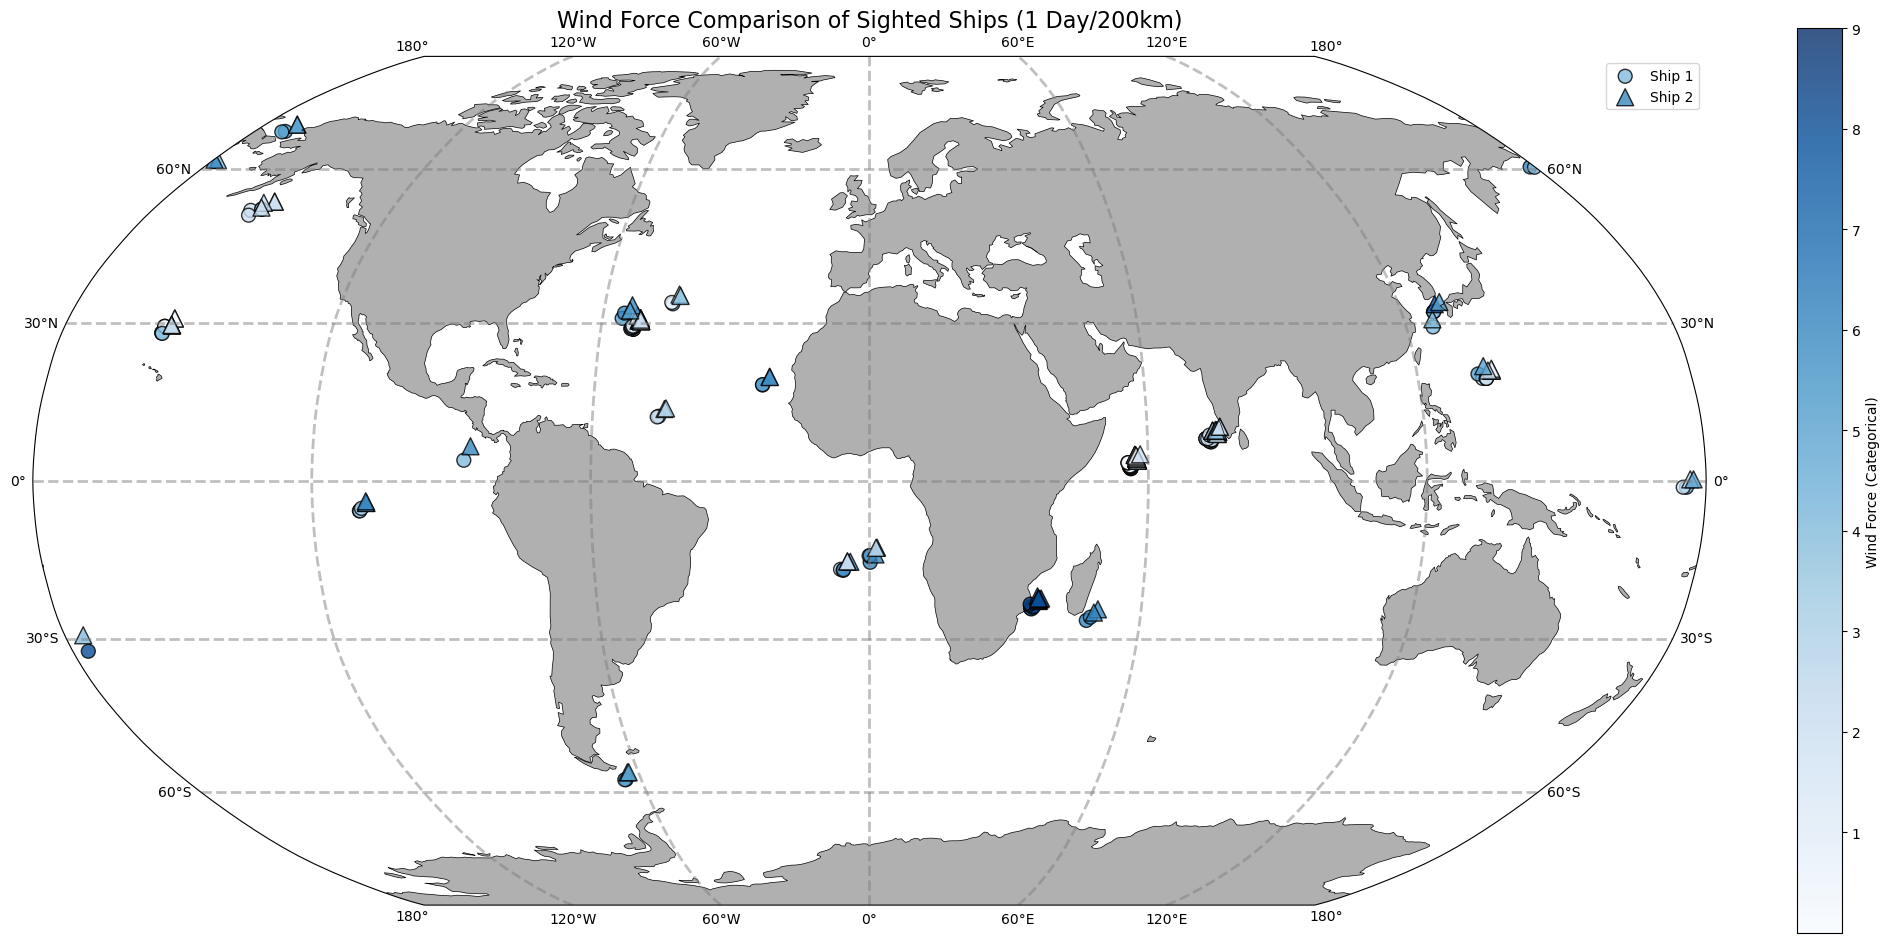

In [29]:
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
ax.set_global()
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')

norm = mcolors.Normalize(vmin=df_200_1d[['Wind Force_1', 'Wind Force_2']].min().min(), 
                         vmax=df_200_1d[['Wind Force_1', 'Wind Force_2']].max().max())

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
# plot ship 1 as circle
sc1 = ax.scatter(df_200_1d['Longitude_1'] - .5, df_200_1d['Latitude_1'] - .5, 
                 c=df_200_1d['Wind Force_1'], cmap='Blues', norm = norm,
                 marker='o', s=100, edgecolor='black', label='Ship 1', 
                 alpha=0.8, transform=ccrs.PlateCarree())
# plot sip 2 as a triangle
sc2 = ax.scatter(df_200_1d['Longitude_2'] + 1, df_200_1d['Latitude_2'] + 1, 
                 c=df_200_1d['Wind Force_2'], cmap='Blues', norm = norm,
                 marker='^', s=150, edgecolor='black', label='Ship 2',
                 alpha=0.8, transform=ccrs.PlateCarree())

# Titles and Labels
plt.title("Wind Force Comparison of Sighted Ships (1 Day/200km)", fontsize=16)
cbar = fig.colorbar(sc1, ax=ax, label="Wind Force (Categorical)", fraction=0.025, pad=0.05)
cbar.set_ticks(np.linspace(1, 9, num=9))  # Set tick marks from 1 to 9

# Legend
plt.legend()
plt.tight_layout()
plt.savefig('myWindForceComparison')
plt.show()

In [191]:
i = 0
df_d = df_final.loc[(df_final['Distance_km'] <= 200) &
                    (df_final['Date Difference'] <= pd.Timedelta(days=1))]
wfd_dict = {}
while i < 250:
    df_l = df_d[df_d['Distance_km'].between(i, i + 50)] 
    wfd_dict[f"Distance: {i}-{i+50}"] = df_l['Wind Force Difference'].value_counts().to_dict()
    i += 50 
wfd_dict

{'Distance: 0-50': {0.0: 22, 1.0: 20, 4.0: 4, 2.0: 4, 3.0: 2},
 'Distance: 50-100': {0.0: 14, 2.0: 11, 1.0: 5, 3.0: 2, 4.0: 2},
 'Distance: 100-150': {2.0: 4, 0.0: 4, 1.0: 2},
 'Distance: 150-200': {0.0: 4, 3.0: 2},
 'Distance: 200-250': {}}

In [242]:
i = 50
while i < 300:
    j = 0
    while j < 7:
        df_n = df_final.loc[(df_final['Distance_km'] <= i) &
                            (df_final['Date Difference'] <= pd.Timedelta(days=j)) & 
                            (df_final['Wind Force Difference'] <= 2)]
        
        df_d = df_final.loc[(df_final['Distance_km'] <= i) & 
                            (df_final['Date Difference'] <= pd.Timedelta(days=j)) & 
                            (df_final['Wind Force Difference'] > 2)]
        
        n = df_n['Wind Force Difference'].value_counts().sum()
        d = df_d['Wind Force Difference'].value_counts().sum()
        
        # Avoid division by zero
        accuracy_ratio = n / d if d != 0 else None
        
        print(f"Distance: {i}, Days: {j}, Accuracy Ratio: {accuracy_ratio}",len(df_n['Wind Force Difference']) + len(df_d['Wind Force Difference']))

        j += 1 

    i += 50
# distance 200 days 1

Distance: 50, Days: 0, Accuracy Ratio: 12.5 27
Distance: 50, Days: 1, Accuracy Ratio: 7.666666666666667 52
Distance: 50, Days: 2, Accuracy Ratio: 5.777777777777778 61
Distance: 50, Days: 3, Accuracy Ratio: 4.818181818181818 64
Distance: 50, Days: 4, Accuracy Ratio: 4.416666666666667 65
Distance: 50, Days: 5, Accuracy Ratio: 3.7857142857142856 67
Distance: 50, Days: 6, Accuracy Ratio: 3.6666666666666665 70
Distance: 100, Days: 0, Accuracy Ratio: 5.833333333333333 41
Distance: 100, Days: 1, Accuracy Ratio: 7.6 86
Distance: 100, Days: 2, Accuracy Ratio: 6.928571428571429 111
Distance: 100, Days: 3, Accuracy Ratio: 5.6 132
Distance: 100, Days: 4, Accuracy Ratio: 5.391304347826087 147
Distance: 100, Days: 5, Accuracy Ratio: 5.2 155
Distance: 100, Days: 6, Accuracy Ratio: 4.724137931034483 166
Distance: 150, Days: 0, Accuracy Ratio: 5.833333333333333 41
Distance: 150, Days: 1, Accuracy Ratio: 8.6 96
Distance: 150, Days: 2, Accuracy Ratio: 8.071428571428571 127
Distance: 150, Days: 3, Accurac

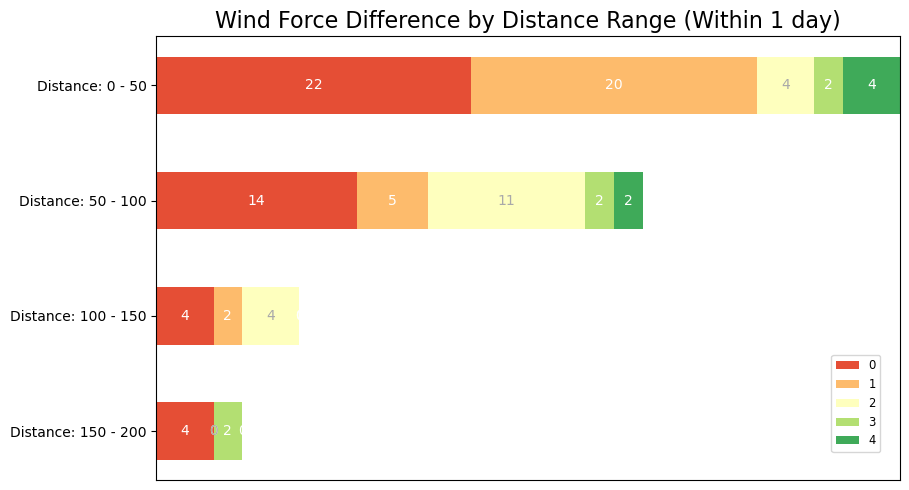

In [249]:
category_names = ['0','1','2','3','4']
results = {
    'Distance: 0 - 50': [22,20,4,2,4],
    'Distance: 50 - 100': [14,5,11,2,2],
    'Distance: 100 - 150': [4,2,4,0,0],
    'Distance: 150 - 200': [4,0,0,2,0]
}
# {'Distance: 0-50': {0.0: 22, 1.0: 20, 4.0: 4, 2.0: 4, 3.0: 2},
#  'Distance: 50-100': {0.0: 14, 2.0: 11, 1.0: 5, 3.0: 2, 4.0: 2},
#  'Distance: 100-150': {2.0: 4, 0.0: 4, 1.0: 2},
#  'Distance: 150-200': {0.0: 4, 3.0: 2},
#  'Distance: 200-250': {}}

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.set_title('Wind Force Difference by Distance Range (Within 1 day)', fontsize=16)
    
    ax.legend(ncol = 1,bbox_to_anchor=(.9, .05),
              loc='lower left', fontsize='small')
    plt.tight_layout()
    
    return fig, ax


survey(results, category_names)
plt.savefig('wfd_bar')
plt.show()

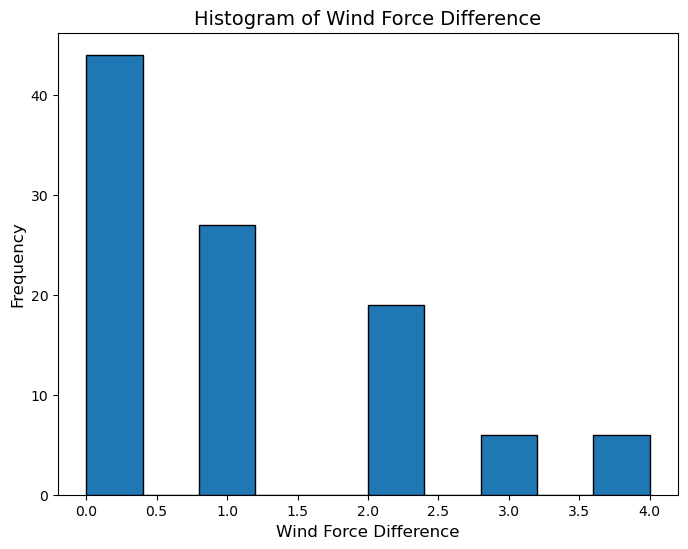

In [230]:
plt.figure(figsize=(8, 6))  # Set figure size

# Plot histogram for 'Wind Force Difference'
plt.hist(df_200_1d['Wind Force Difference'], bins=10, edgecolor='black')  # Adjust bins as needed

# Add labels and title
plt.title('Histogram of Wind Force Difference', fontsize=14)
plt.xlabel('Wind Force Difference', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Display the plot
plt.savefig('wfd_hist')
plt.show()

In [239]:
print(len(df_u))
print(len(df_final))
print(len(df_200_1d))
print(len(df_200_1d['Wind Force Difference']))
print(df_200_1d.info())

6444
55644
102
102
<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, 4886 to 51572
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   ID_1                   102 non-null    float64        
 1   LogBook ID_1           102 non-null    object         
 2   Latitude_1             102 non-null    float64        
 3   Longitude_1            102 non-null    float64        
 4   Wind Speed/Force_1     102 non-null    object         
 5   Wind Force_1           102 non-null    float64        
 6   Ship Sightings_1       102 non-null    object         
 7   Entry Date Time_1      102 non-null    datetime64[ns] 
 8   Matched_Ship           102 non-null    object         
 9   ID_2                   102 non-null    float64        
 10  LogBook ID_2           102 non-null    object         
 11  Latitude_2             102 non-null    float64        
 12  Longitude_2            102 non-

In [27]:
df_filtered = df_200_1d[df_200_1d['Wind Force Difference'] >= 3]
df_filtered

,ID_1,LogBook ID_1,Latitude_1,Longitude_1,Wind Speed/Force_1,Wind Force_1,Ship Sightings_1,Entry Date Time_1,Matched_Ship,ID_2,LogBook ID_2,Latitude_2,Longitude_2,Wind Speed/Force_2,Wind Force_2,Ship Sightings_2,Entry Date Time_2,Distance_km,Date Difference,Wind Force Difference
6944,52579.0,Cambria (Ship) 1847-1851,-0.733333,176.283333,fine trades,5.0,Henry Kneeland of New Bedford,1850-01-14 12:00:00,Cambria,56086.0,Henry Kneeland (ship) 1848-1851,-0.733333,175.583333,light breezes,2.0,"spoke Cambria, New Bedford",1850-01-14 12:00:00,77.917304,0 days,3.0
19170,82194.0,Gage H. Phillips (Schooner) 1878-1880,-13.750000,0.416667,light breezes,2.0,Gammed with B.K. Pioneer,1880-01-31 12:00:00,Gage,71629.0,Pioneer (Bark) 1877-1880,-13.716667,0.633333,strong trades,6.0,Spoke with schooner Gage H. Phillips,1880-01-31 12:00:00,23.722516,0 days,4.0
27902,90262.0,Gideon Howland (ship) 1836-1838,-5.216667,-109.433333,strong breezes,6.0,"""spoke the Timoleon New Bedford Capt Coffin (B...",1836-07-13 12:00:00,Gideon,96177.0,Timoleon (Ship) 1835-1839,-5.216667,-109.333333,gentle breezes,3.0,"""spoke the ship Gideon Howland""",1836-07-14 12:00:00,11.086147,1 days,3.0
29473,56086.0,Henry Kneeland (ship) 1848-1851,-0.733333,175.583333,light breezes,2.0,"spoke Cambria, New Bedford",1850-01-14 12:00:00,Henry,52579.0,Cambria (Ship) 1847-1851,-0.733333,176.283333,fine trades,5.0,Henry Kneeland of New Bedford,1850-01-14 12:00:00,77.917304,0 days,3.0
43801,37086.0,Mechanic (Ship) 1846-1851,20.783333,133.845833,fine breezes,5.0,Splendid of Edgartown,1848-03-26 12:00:00,Mechanic,46815.0,Splendid (Ship) 1846-1849,19.950000,135.500000,light breezes,2.0,Mechanic of Newport,1848-03-25 12:00:00,195.794576,1 days,3.0
44233,39895.0,Medford (Brig) 1846-1851,-16.333333,-5.800000,light winds,2.0,Thomas Winslow of Westport,1847-03-02 12:00:00,Medford,16414.0,Thomas Winslow (Brig) 1846-1847,-16.400000,-5.166667,strong winds,6.0,"""gaming with the Medford""",1847-03-02 12:00:00,68.064411,0 days,4.0
44299,41798.0,Medford (Brig) 1846-1851,34.116667,-44.133333,moderate breezes,4.0,E. Nickerson of Provincetown Walter Irving of ...,1850-08-14 12:00:00,Medford,84439.0,Walter Irving (Schooner) 1850,34.383333,-44.416667,calms,0.0,The Medford,1850-08-15 12:00:00,39.448046,1 days,4.0
45985,71629.0,Pioneer (Bark) 1877-1880,-13.716667,0.633333,strong trades,6.0,Spoke with schooner Gage H. Phillips,1880-01-31 12:00:00,Pioneer,82194.0,Gage H. Phillips (Schooner) 1878-1880,-13.750000,0.416667,light breezes,2.0,Gammed with B.K. Pioneer,1880-01-31 12:00:00,23.722516,0 days,4.0
49811,46815.0,Splendid (Ship) 1846-1849,19.950000,135.500000,light breezes,2.0,Mechanic of Newport,1848-03-25 12:00:00,Splendid,37086.0,Mechanic (Ship) 1846-1851,20.783333,133.845833,fine breezes,5.0,Splendid of Edgartown,1848-03-26 12:00:00,195.794576,1 days,3.0
51256,16414.0,Thomas Winslow (Brig) 1846-1847,-16.400000,-5.166667,strong winds,6.0,"""gaming with the Medford""",1847-03-02 12:00:00,Thomas,39895.0,Medford (Brig) 1846-1851,-16.333333,-5.800000,light winds,2.0,Thomas Winslow of Westport,1847-03-02 12:00:00,68.064411,0 days,4.0


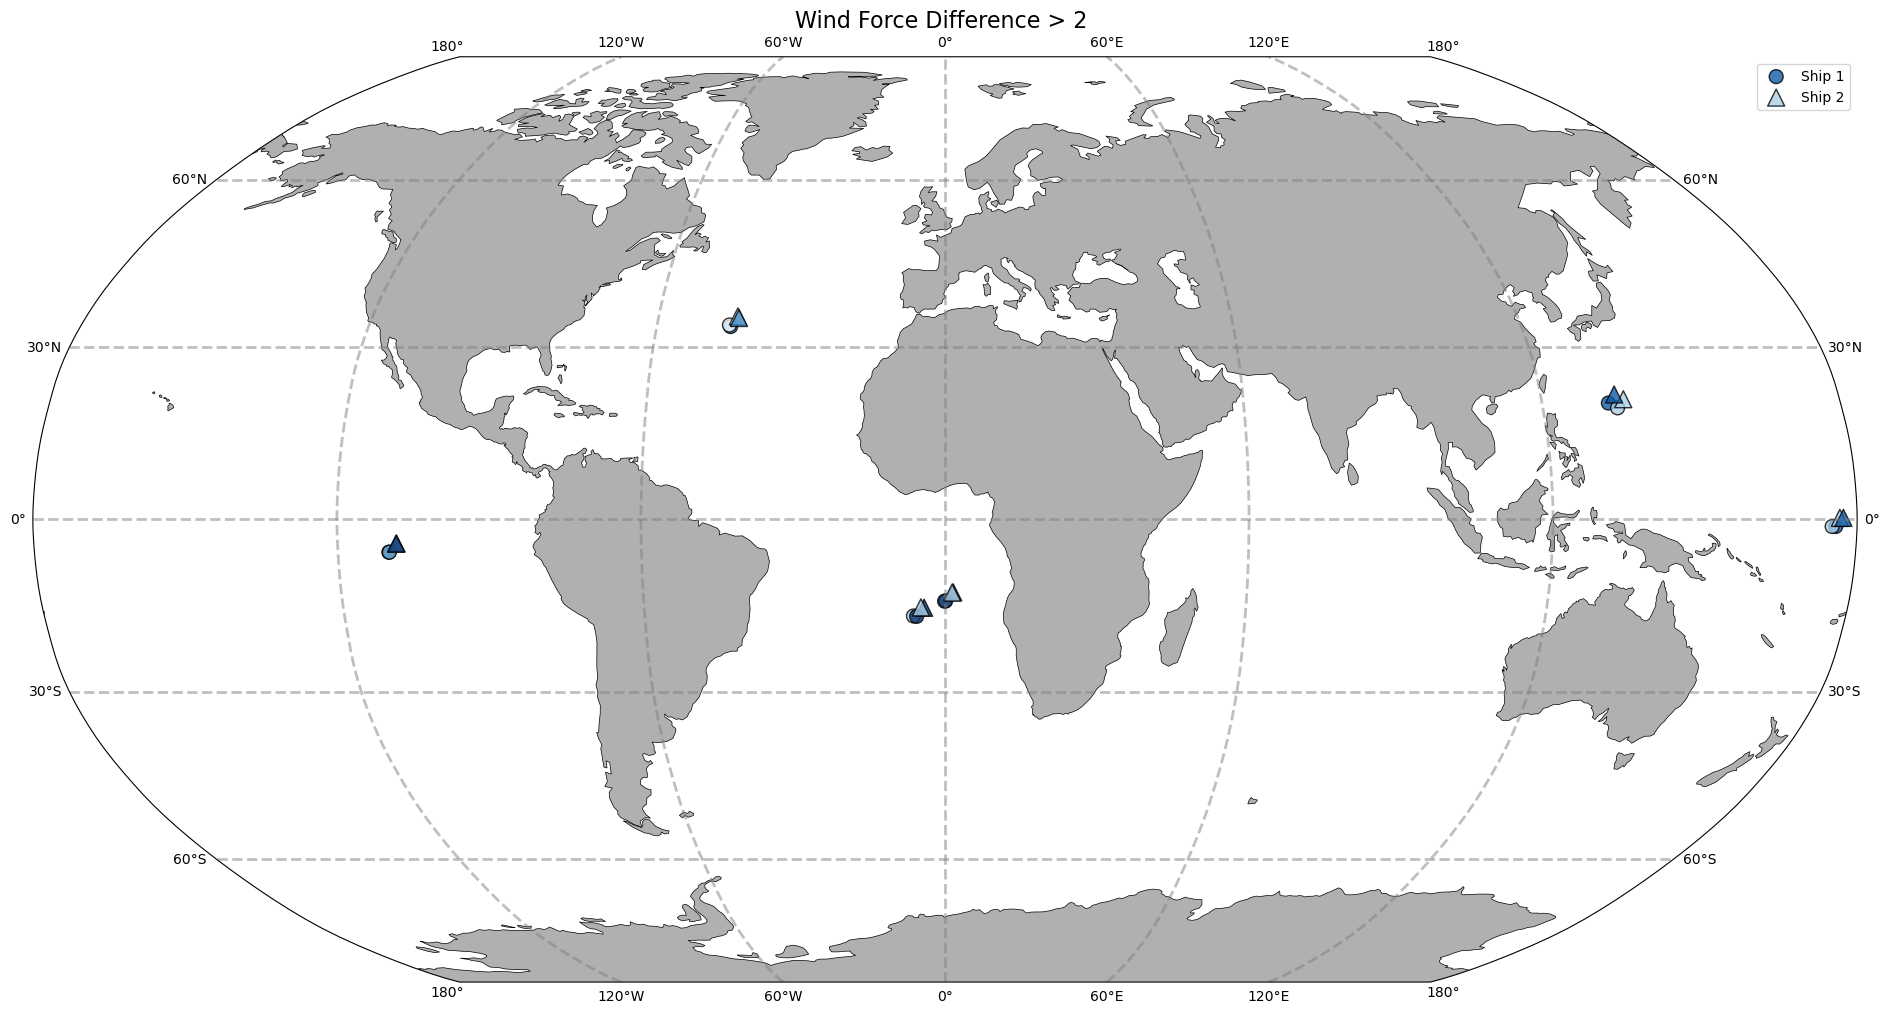

In [30]:
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
ax.set_global()
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')

norm = mcolors.Normalize(vmin=df_filtered[['Wind Force_1', 'Wind Force_2']].min().min(), 
                         vmax=df_filtered[['Wind Force_1', 'Wind Force_2']].max().max())

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')

sc1 = ax.scatter(df_filtered['Longitude_1'] - .5, df_filtered['Latitude_1'] - .5, 
                 c=df_filtered['Wind Force_1'], cmap='Blues', norm = norm,
                 marker='o', s=100, edgecolor='black', label='Ship 1', 
                 alpha=0.8, transform=ccrs.PlateCarree())

sc2 = ax.scatter(df_filtered['Longitude_2'] + 1, df_filtered['Latitude_2'] + 1, 
                 c=df_filtered['Wind Force_2'], cmap='Blues', norm = norm,
                 marker='^', s=150, edgecolor='black', label='Ship 2',
                 alpha=0.8, transform=ccrs.PlateCarree())

# Titles and Labels
plt.title("Wind Force Difference > 2 ", fontsize=16)

cbar.set_ticks(np.linspace(1, 9, num=9))  # Set tick marks from 1 to 9

# Legend
plt.legend()
plt.tight_layout()
plt.show()